In [22]:
import numpy as np
from constants import *
import matplotlib.pyplot as plt

In [133]:
# %% Get the scattering angle alpha
def get_alpha(d,Rstar,theta):
    """
    Get the scattering angle alpha via law of cosine.
    If we did it with law of cosine, then for the case of alpha > 0.5pi,
    it will always return pi - alpha which cannot reflect the pratical
    situation
    
    Input
    ------
    d: the l.o.s distance d
    Rstar: the distance between Earth and SN
    theta: the open-angle in rad
    
    Output
    ------
    alpha: scattering angle alpha in rad
    """
    # Get D^2
    D2 = get_D(d,Rstar,theta,True)
    D = np.sqrt(D2)
    # Get cos(alpha)
    cosAlpha = (Rstar**2 - D2 - d**2)/(2*D*d)
    # Get alpha via arccos
    alpha = np.arccos(cosAlpha)
    return alpha


# %% Calculate D
def get_D(d,Rstar,theta,is_square = False):
    """
    Calculate the distance between SN and boosted point D
    
    Input
    ------
    d: the l.o.s distance d
    Rstar: the distance between Earth and SN
    theta: the open-angle in rad
    is_square: return the square of such distance, default is False
    
    Output
    ------
    D: the distance D
    """
    # Calculate D^2 via law of cosine
    D2 = d**2 + Rstar**2 - 2*d*Rstar*np.cos(theta)
    if is_square is False:
        return np.sqrt(D2)
    elif is_square is True:
        return D2
    else:
        raise ValueError('\'is_square\' must be either True or False')
    

# %% Calculate ell
def get_ell(d,Re,theta,beta,is_square = False):
    """
    Calculate the distance ell
    
    Input
    ------
    d: the l.o.s distance d
    Re: the distance between Earth and the GC
    theta: the open-angle in rad
    beta: the off-center angle in rad
    is_square: return the square of such distance, default is False
    
    Output
    ------
    ell: the distance ell
    """
    # Calculate ell^2 via law of cosine
    ell2 = Re**2 + (d*np.cos(theta))**2 - 2*Re*d*np.cos(theta)*np.cos(beta)
    if is_square is False:
        return np.sqrt(ell2)
    elif is_square is True:
        return ell2
    else:
        raise ValueError('\'is_square\' must be either True or False')


# %% Calculate r'
def get_rprime(d,Rstar,Re,theta,phi,beta,tolerance = 1e-5):
    """
    Calculate the distance from boosted point to GC r'
    
    Input
    ------
    d: the l.o.s distance d
    Rstar: the distance between Earth and SN
    Re: the distance between Earth and the GC
    theta: the open-angle in rad
    phi: the azimuth angle in rad
    beta: the off-center angle in rad
    
    Output
    ------
    r': the distance r'
    """
    # ell^2
    ell2 = get_ell(d,Re,theta,beta,True)
    # D^2
    D2 = get_D(d,Rstar,theta,True)
    # h
    h = d*np.sin(theta)
    # cos(iota) and iota
    cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
    # Using sin(arccos(x)) = sqrt(1-x^2)
    if 0 <= np.abs(cosIota) <= 1:
        # normal case
        sinIota = np.sqrt(1 - cosIota**2)
    elif np.abs(cosIota) - 1 < tolerance:
        # cosIota is outside the valid range but its value is still within the
        # tolerance, which implies abs(cosIota) = 1 is still ok to our calculation.
        # Since cosIota is slight larger than 1 but within the tolerance, we switch 1 - x^2 to x^2 - 1
        # to avoid minus sign occuring in square root
        sinIota = np.sqrt(cosIota**2 - 1)
    else:
        # cosIota is not only outside the valid range but also untolerable
        print('cosIota value is outside the tolarance range, please check again')
    # r'^2
    rp2 = ell2*cosIota**2 + (np.sqrt(ell2)*sinIota - h*np.sin(phi))**2 + h**2*np.cos(phi)**2
    return np.sqrt(rp2)


# %% Calculate l.o.s d for a given time
def get_d(t,vx,Rstar,theta):
    """
    Calculate the distance l.o.s d
    
    Input
    ------
    t: the arrival time of BDM at Earth relative to the first SN neutrino on the Earth
    vx: BDM velocity in the unit of light speed
    Rstar: the distance between Earth and SN
    theta: the open-angle in rad
    
    Output
    ------
    d: the l.o.s
    """
    zeta = Rstar + light_speed*t/kpc2cm
    cosTheta = np.cos(theta)
    d = (zeta - Rstar*vx*cosTheta - np.sqrt((Rstar**2 - zeta**2)*(1 - vx**2) + (Rstar*vx*cosTheta - zeta)**2))*vx/(1-vx**2)
    return d


# %% BDM velocity in the unit of light speed
def vx(Tx,mx):
    """
    The BDM velocity in the unit of light speed
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    
    Output
    ------
    vx: VDM velocity
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)

In [164]:
t = 1e-1*yr2s
Tx = 10
mx = 1e-2
theta_ls = np.logspace(-7,0.196,50)
phi = 0.7
Rstar = 5
beta = 0

In [165]:
d_ls = []
ell_ls =[]
D_ls = []
r_ls = []
for theta in theta_ls:
    d_ls.append(get_d(t,vx(Tx,mx),Rstar,theta))

for i in range(50):
    ell_ls.append(get_ell(d_ls[i],Re,theta_ls[i],beta))
    D_ls.append(get_D(d_ls[i],Rstar,theta_ls[i]))
    r_ls.append(get_rprime(d_ls[i],Rstar,Re,theta_ls[i],phi,beta,1))

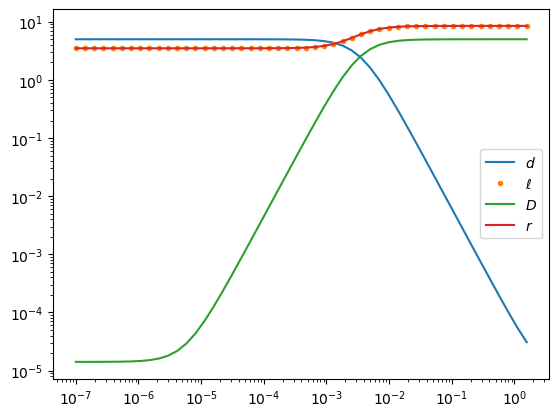

In [166]:
plt.plot(theta_ls,d_ls,label='$d$')
plt.plot(theta_ls,ell_ls,'.',label=r'$\ell$')
plt.plot(theta_ls,D_ls,label='$D$')
plt.plot(theta_ls,r_ls,label='$r$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [147]:
len(ell_ls)

50

In [14]:
rPrime(D,Rstar,Re,theta,phi,beta)

1.5143760438933807

In [20]:
get_rprime(d_los(D,Rstar,theta),Rstar,Re,theta,phi,beta,tolerance = 1e-15)

1.5143760438933807

In [15]:
print(d_los(D,Rstar,theta),
sanityCheckTheta(D,Rstar,theta),
sanityCheckAlpha(D,Rstar,theta),
ell(Rstar,Re,theta,beta),
(Re- d_los(D,Rstar,theta)*np.cos(theta)),
rPrime(D,Rstar,Re,theta,phi,beta))

7.005658150586865 True True 1.5374999363678117 1.4977987188087702 1.5143760438933807


In [36]:
getAlpha(D,Rstar,theta)/np.pi

0.028366203012016263

In [37]:
sanityCheckAlpha(D,Rstar,theta)

True

In [40]:
np.cos(theta)

0.9995065603657316

In [46]:
np.arccos((-D**2 + Rstar**2 + d_los(D,Rstar,theta,True))/(2*Rstar*d_los(D,Rstar,theta)))

3.110176727053904

In [44]:
d_los(D,Rstar,theta)

2.5009535579126934

In [48]:
np.pi-theta

3.1101767270538954